In [ ]:
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
# Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
# с аугментацией (самописной, с использованием Pytorch встроенных методов)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from torchvision import models
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split


In [255]:
# Здесь нет класса MyOwnCifar - выдает ошибку
# AttributeError: Can't get attribute 'MyCifar' on <module '__main__' (built-in)>
# Проблему пришлось обходить топорно: на каждую сеть пришлось импортировать
# данные отдельно и вкладывать импорт прямо в скачивание
# считаю это плохим решением, т.к для датасета из жизни такой трюк не сработает
# надеюсь, смогу решить проблему позже)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR100(root='/content/drive/MyDrive/PyTorch/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='content/drive/MyDrive/PyTorch/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting content/drive/MyDrive/PyTorch/cifar-100-python.tar.gz to content/drive/MyDrive/PyTorch/


In [104]:
len(trainloader)

782

In [100]:
target_list = trainset.classes

In [101]:
def show_cifar(batch, num, if_tensor=False):
    plt.figure(figsize=(10, 10))
    for i in range(num):
        ax = plt.subplot(np.sqrt(num), np.sqrt(num), i + 1)
        if if_tensor:
            plt.imshow(batch[i][0].permute(1, 2, 0))
        else:
            plt.imshow(batch[i][0])
        ax.set_title(target_list[batch[i][1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


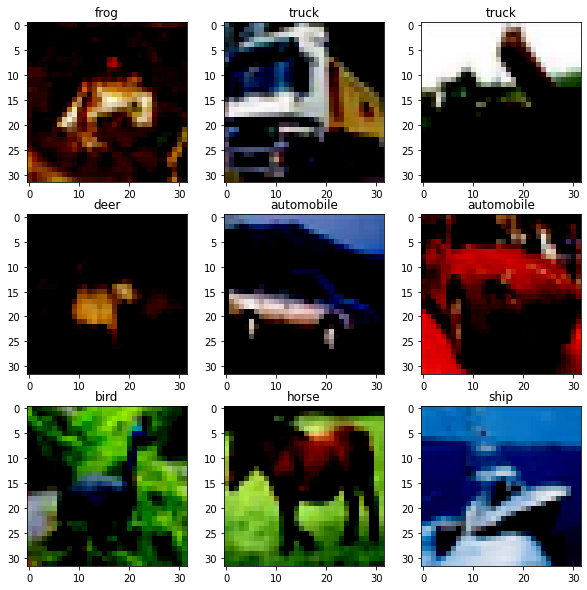

In [102]:
show_cifar(trainset, 9, if_tensor=True)

In [256]:
# Тут все максимально грустно. Когда пишу свою архитектуру,
# обычно выдает ошибку NotImplementedError, стоит только отойти от
# примера из вебинара(

class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.bn1 = torch.nn.BatchNorm2d(3)
        self.conv1 = torch.nn.Conv2d(3, 30, 3)
        self.bn2 = torch.nn.BatchNorm2d(30)
        self.conv2 = torch.nn.Conv2d(30, 60, 3)
        self.bn3 = torch.nn.BatchNorm2d(60)
        self.conv3 = torch.nn.Conv2d(60, 120, 3)
        self.bn4 = torch.nn.BatchNorm2d(120)
        self.dr = torch.nn.Dropout(0.25)
        self.l1 = torch.nn.Linear(480, 400)
        self.l2 = torch.nn.Linear(400, 200)
        self.l3 = torch.nn.Linear(200, 100)

    def forward(self, x):
        
        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn3(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn4(x)
        x = x.view(x.size(0), -1)
        x = self.dr(x)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        
        return x    
    

In [257]:
net = Network()

In [258]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [259]:
# Ошибка большая, но на удивление этот вариант вышел самым удачным из всех
# может если будет больше эпох, результат будет получше
for epoch in tqdm(range(5)):  
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in testloader:
        output = net(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 20%|██        | 1/5 [01:45<07:02, 105.61s/it]

Epoch 0 valid_loss 666.5866088867188


 40%|████      | 2/5 [03:42<05:36, 112.32s/it]

Epoch 1 valid_loss 598.2964477539062


 60%|██████    | 3/5 [05:38<03:47, 113.94s/it]

Epoch 2 valid_loss 546.8440551757812


 80%|████████  | 4/5 [07:30<01:53, 113.22s/it]

Epoch 3 valid_loss 509.8744812011719


100%|██████████| 5/5 [09:16<00:00, 111.25s/it]

Epoch 4 valid_loss 469.4774475097656
Training is finished!


In [260]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

batch_size = 64

trainset_1 = torchvision.datasets.CIFAR100(root='/content/drive/MyDrive/PyTorch/', train=True,
                                        download=True, transform=transform)
trainloader_1 = torch.utils.data.DataLoader(trainset_1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_1 = torchvision.datasets.CIFAR100(root='content/drive/MyDrive/PyTorch/', train=False,
                                       download=True, transform=transform)
testloader_1 = torch.utils.data.DataLoader(testset_1, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [261]:
resnet_50 = models.resnet50(pretrained=True)

In [262]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [263]:
set_parameter_requires_grad(resnet_50, True)


In [264]:
resnet_50.fc = torch.nn.Linear(2048, 100)

In [265]:
res_criterion = nn.CrossEntropyLoss()
res_optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [266]:
# Ошибка больше вдвое и на последней эпохе подскочила выше чем в начале
# Есть у меня подозрение что дело в ровности моих рук, прошу указать на ошибки
for epoch in tqdm(range(5)):  
    resnet_50.train()
    for i, data in enumerate(trainloader_1, 0):
        inputs, labels = data[0], data[1]
        res_optimizer.zero_grad()

        outputs = resnet_50(inputs)
        loss = res_criterion(outputs, labels)
        loss.backward()
        res_optimizer.step()
        
    resnet_50.eval()
    loss_accumed = 0
    for X, y in testloader_1:
        output = resnet_50(X)
        loss = res_criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 20%|██        | 1/5 [08:26<33:45, 506.43s/it]

Epoch 0 valid_loss 746.2565307617188


 40%|████      | 2/5 [16:45<25:07, 502.38s/it]

Epoch 1 valid_loss 745.351806640625


 60%|██████    | 3/5 [25:01<16:38, 499.43s/it]

Epoch 2 valid_loss 745.3870849609375


 80%|████████  | 4/5 [33:21<08:19, 499.65s/it]

Epoch 3 valid_loss 743.1331176757812


100%|██████████| 5/5 [41:40<00:00, 500.10s/it]

Epoch 4 valid_loss 747.2385864257812
Training is finished!


In [267]:
augmentation = torchvision.transforms.Compose([
    transforms.ColorJitter(brightness=0.2, hue=0.2, contrast=0.1),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(p=0.35),
    transforms.RandomRotation(degrees=(45, 45)),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

In [268]:
trainset_2 = torchvision.datasets.CIFAR100(root='/content/drive/MyDrive/PyTorch/', train=True,
                                        download=True, transform=augmentation)
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=64,
                                          shuffle=True, num_workers=2)
testset_2 = torchvision.datasets.CIFAR100(root='content/drive/MyDrive/PyTorch/', train=False,
                                       download=True, transform=transform)
testloader_2 = torch.utils.data.DataLoader(testset_2, batch_size=64,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


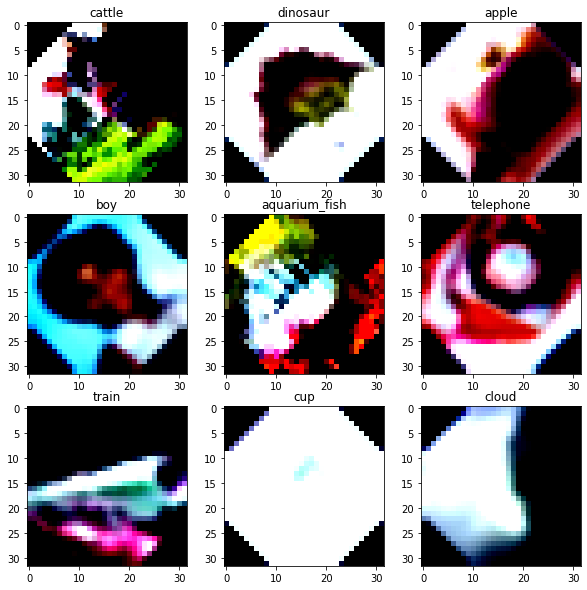

In [269]:
#Смотрим что получилось после трансформации и не особо удивляемся, что стало с ошибкой после обучения(
target_list = trainset_2.classes
show_cifar(trainset_2, 9, if_tensor=True)

In [270]:
resnet_50_2 = models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet_50_2, True)
resnet_50_2.fc = torch.nn.Linear(2048, 100)

In [271]:
aug_criterion = nn.CrossEntropyLoss()
aug_optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [272]:
#Здесь ошибка скачет от эпохе к эпохе.Довольно неудачно, как исправить? На stackoverflow нашла информацию, 
#что трансформация только меняет изображения. Есть-ли в Pytorch способ трансформировать и добавить к
# существующему датасету(как в tensorflow)? 
for epoch in tqdm(range(5)):  
    resnet_50_2.train()
    for i, data in enumerate(trainloader_2, 0):
        inputs, labels = data[0], data[1]
        aug_optimizer.zero_grad()

        outputs = resnet_50_2(inputs)
        loss = aug_criterion(outputs, labels)
        loss.backward()
        aug_optimizer.step()
        
    resnet_50_2.eval()
    loss_accumed = 0
    for X, y in testloader_2:
        output = resnet_50_2(X)
        loss = aug_criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 20%|██        | 1/5 [09:11<36:47, 551.81s/it]

Epoch 0 valid_loss 958.5641479492188


 40%|████      | 2/5 [18:15<27:20, 546.95s/it]

Epoch 1 valid_loss 901.7088012695312


 60%|██████    | 3/5 [27:17<18:09, 544.74s/it]

Epoch 2 valid_loss 999.5291137695312


 80%|████████  | 4/5 [36:18<09:03, 543.34s/it]

Epoch 3 valid_loss 1034.383056640625


100%|██████████| 5/5 [45:20<00:00, 544.16s/it]

Epoch 4 valid_loss 1021.4369506835938
Training is finished!
